In [1]:
import tensorflow as tf
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)


[] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
%%time
import pyarrow.parquet as pq
import pandas as pd
import re
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import pos_tag # 词性
from nltk.tokenize import word_tokenize # 分词
from nltk.corpus import stopwords # 停用词
from nltk.stem import PorterStemmer, WordNetLemmatizer # 词干化，词态统一
from tqdm import tqdm  # 显示处理进度
tqdm.pandas(desc="Processing excerpts")



lemmatizer = WordNetLemmatizer()
#Different sources of stopwords
nltk_stopwords = set(stopwords.words('english')) 
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
wordcloud_stopwords = set(STOPWORDS)
with open('.\\dictionaries\\expandedstopwords.txt', 'r') as file:
    txt_stopwords = [line.strip() for line in file.readlines()]
    
stopwords_df = pd.DataFrame({'Words': txt_stopwords})
additional_stopwords = set(stopwords_df.to_numpy().flatten())

CPU times: total: 500 ms
Wall time: 3.22 s


In [3]:
%%time
# 清洗文本数据
def clean_text(text):
    # 去除特殊字符和标点符号
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # 小写化文本
    text = text.lower()
    return text

# 分词和词形还原
def tokenize_and_lemmatize(text):
    tqdm.pandas(desc="Tokenizing")
    # 分词
    words = nltk.word_tokenize(text)
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# 去停用词
def remove_stopwords(tokens):
    stop_words = sklearn_stopwords.union(additional_stopwords, wordcloud_stopwords, nltk_stopwords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# 词干化
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
# 一次性解决四个任务，优化代码，减少循环次数。建议apply
def preprocess_text(text):
    # 基本处理
    cleaned_text = clean_text(text)
    # 分词和词形还原
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    # 去停用词
    non_stop_words = remove_stopwords(lemmatized_tokens)
    # 词干化
    stemmed_tokens = stem_tokens(non_stop_words)
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
# 假设我们有经济危机时间戳的数据列表
crisis_timestamps = [
    "1986:1 Credit disrupt.-minus",
    "1990:1 Minor crisis-reg.",
    "1990:2 Moderate crisis-minus",
    "1991:1 Minor crisis-minus",
    "1991:2 Credit disrupt.-plus",
    "1992:1 Credit disrupt.-reg.",
    "1998:2 Credit disrupt.-plus",
    "2007:1 Credit disrupt.-minus",
    "2007:2 Moderate crisis-minus",
    "2008:1 Moderate crisis-plus",
    "2008:2 Extreme crisis-reg.",
    "2009:1 Major crisis-minus",
    "2009:2 Moderate crisis-minus",
    "2010:1 Minor crisis-plus",
    "2010:2 Credit disrupt.-plus",
    "2011:2 Credit disrupt.-reg.",
    "2012:1 Credit disrupt.-minus",
    "2012:2 Credit disrupt.-minus"
]

# 定义危机的严重程度和修饰符的标量值
crisis_severity = {
    'Minor crisis': 4,
    'Moderate crisis': 7,
    'Major crisis': 10,
    'Extreme crisis': 13,
    'Credit disrupt.': 1  
}

# 对修饰符进行数值调整
modifier_adjustment = {
    'minus': 0.0,
    'plus': 2.0,
    'reg.': 1.0
}

# 创建一个空的DataFrame来存储结果
crisis_data = pd.DataFrame(columns=['Year', 'Severity', 'Binary_Crisis'])

# 处理每个时间戳，填充DataFrame
for timestamp in crisis_timestamps:
    # 解析年份和描述
    year, _, description = timestamp.partition(':')
    year = int(year)  # 转换年份为整数
    # 解析危机类型和修饰符
    for crisis_type in crisis_severity:
        if crisis_type in description:
            severity_value = crisis_severity[crisis_type]
            # 找到修饰符并进行调整
            for modifier in modifier_adjustment:
                if modifier in description:
                    severity_value += modifier_adjustment[modifier]
                    break  # 找到修饰符后无需继续查找
            # 添加到DataFrame
            crisis_data = crisis_data._append({
                'Year': year,
                'Severity': severity_value,
                'Binary_Crisis': 1  # 如果记录中有危机描述则标为1
            }, ignore_index=True)
            break  # 危机类型已找到，无需继续其它类型的检查

# 确保年份是整数类型
crisis_data['Year'] = crisis_data['Year'].astype(int)
crisis_data['Binary_Crisis'] = crisis_data['Binary_Crisis'].astype(int)
# 输出结果
crisis_data

C:\Users\ROG\AppData\Local\Temp\ipykernel_29488\2301511474.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crisis_data = crisis_data._append({


,Year,Severity,Binary_Crisis
0,1986,1.0,1
1,1990,5.0,1
2,1990,7.0,1
3,1991,4.0,1
4,1991,3.0,1
5,1992,2.0,1
6,1998,3.0,1
7,2007,1.0,1
8,2007,7.0,1
9,2008,9.0,1


In [6]:
# 首先，对同一年份的危机严重性分数求和并取平均值
# 对Binary_Crisis采取最大值，因为如果有危机，Binary_Crisis应该是1
aggregated_crisis_data = crisis_data.groupby('Year').agg({'Severity': 'mean', 'Binary_Crisis': 'max'}).reset_index()

# 现在，aggregated_crisis_data 将有每个年份的危机严重性分数总和，且Binary_Crisis为1（如果那年发生了危机）
print(aggregated_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0              1
1   1990       6.0              1
2   1991       3.5              1
3   1992       2.0              1
4   1998       3.0              1
5   2007       4.0              1
6   2008      11.5              1
7   2009       8.5              1
8   2010       4.5              1
9   2011       2.0              1
10  2012       1.0              1


In [7]:
# Find the range of years you want to cover
full_year_range = range(aggregated_crisis_data['Year'].min(), aggregated_crisis_data['Year'].max() + 1)

# Create a DataFrame with all years in the range
all_years_df = pd.DataFrame(full_year_range, columns=['Year'])

# Merge with the existing crisis data
# This will keep all entries from all_years_df and match entries from crisis_data where available
complete_crisis_data = all_years_df.merge(aggregated_crisis_data, on='Year', how='left')

# Fill NaN values with 0 for 'Severity' and 'Binary_Crisis'
complete_crisis_data['Severity'].fillna(0, inplace=True)
complete_crisis_data['Binary_Crisis'].fillna(0, inplace=True)

# The resulting DataFrame will have all years filled, with 0 for missing years
print(complete_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0            1.0
1   1987       0.0            0.0
2   1988       0.0            0.0
3   1989       0.0            0.0
4   1990       6.0            1.0
5   1991       3.5            1.0
6   1992       2.0            1.0
7   1993       0.0            0.0
8   1994       0.0            0.0
9   1995       0.0            0.0
10  1996       0.0            0.0
11  1997       0.0            0.0
12  1998       3.0            1.0
13  1999       0.0            0.0
14  2000       0.0            0.0
15  2001       0.0            0.0
16  2002       0.0            0.0
17  2003       0.0            0.0
18  2004       0.0            0.0
19  2005       0.0            0.0
20  2006       0.0            0.0
21  2007       4.0            1.0
22  2008      11.5            1.0
23  2009       8.5            1.0
24  2010       4.5            1.0
25  2011       2.0            1.0
26  2012       1.0            1.0


In [8]:
%%time
# 加载数据
data = pd.read_parquet('.\\nyt_data.parquet')
data.head()

CPU times: total: 19.3 s
Wall time: 20.3 s


,year,title,excerpt
0,1920,At last the Federal Reserve Board has issued r...,
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...
2,1920,Sanction for Chinese Contracts.,
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...


In [9]:
print(data.describe())

               year
count  1.737091e+07
mean   1.965375e+03
std    2.807526e+01
min    1.920000e+03
25%    1.941000e+03
50%    1.961000e+03
75%    1.990000e+03
max    2.020000e+03


In [10]:
# 过滤出1985年及以后的数据
data_filtered = data[data['year'] >= 1985]

# 显示过滤后的数据描述
data_filtered.describe()

,year
count,5.204829e+06
mean,2.001664e+03
std,9.731762e+00
min,1.985000e+03
25%,1.993000e+03
50%,2.002000e+03
75%,2.009000e+03
max,2.020000e+03


In [11]:
%%time
# 取数据集的10%
data_sample = data_filtered.sample(frac=0.1, random_state=42)
# 查看数据集的样本大小
print("Sample size:", len(data_sample))
data_sample.describe()

Sample size: 520483
CPU times: total: 188 ms
Wall time: 239 ms


,year
count,520483.000000
mean,2001.668742
std,9.738961
min,1985.000000
25%,1993.000000
50%,2002.000000
75%,2009.000000
max,2020.000000


In [12]:
data_sample['processed_excerpt'] = data_sample['excerpt'].apply(preprocess_text)

In [13]:
print(data_sample['processed_excerpt'].values[1])

['photo', 'blue', 'oasi', 'space']


In [14]:
text_excerpt = []
for i in data_sample['processed_excerpt'].values:
    if i != []:
        text_excerpt.append(','.join(i))
    else:
        text_excerpt.append('')
        
text_excerpt

['',
 'photo,blue,oasi,space',
 '',
 '',
 '',
 '',
 '',
 'incid,ha,scar,reput,proudest,workhors,submarin,fleet,wreak,havoc,futur,offic,crew,photo,undercurr,anger,haunt,submarin,greenevil,accid',
 'japan,glimps,art,tough,talk',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'allegedli,doublebil,univers,150000,busi,expens,paid,restitut,univers,declin,comment,yale,professor,step,inquiri,bill',
 '',
 '',
 '',
 '',
 '',
 'recip,photo,mark,militello',
 '',
 '',
 '',
 '',
 'photo,style,piggi',
 '',
 '',
 'describ,scene,celebr,arriv,popular,wait,marc,backstag,chronicl',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'medicalwast,plan,prompt',
 '',
 '',
 '',
 'photo,sign,report,card',
 '',
 'draw,attract,bird,life',
 '',
 '',
 '',
 'treatment,market,studi,photo,idea,trend,herbal,potion,scienc,sick',
 '',
 '',
 'photo,laker,star,treatment,troubl,knick',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'graph,busi,brief,america,canada,bank,post,charg',
 '',
 '',
 '',
 '',

In [15]:
data_sample['processed_txt'] = text_excerpt

In [31]:
%%time
# 从txt文件读取词汇
with open('.\\dictionaries\\unionOfDicts.txt', 'r') as file:
    txt_data = [line.strip() for line in file.readlines()]
    
# 创建包含文本文件中词汇的DataFrame
txt_df = pd.DataFrame({'Word': txt_data})

# 从Excel文件读取词典数据
excel_df = pd.read_excel('.\\dictionaries\\financial_stability.xlsx')

# 合并两个DataFrame
lm_dict = pd.concat([txt_df, excel_df], ignore_index=True)

# 显示合并后的DataFrame
print(lm_dict)

                 Word  Positive  Negative
0      hyperinflation       NaN       NaN
1          fiat money       NaN       NaN
2       law economics       NaN       NaN
3     creditor nation       NaN       NaN
4      mortgage terms       NaN       NaN
...               ...       ...       ...
3567           worsen       NaN       1.0
3568         worsened       NaN       1.0
3569        worsening       NaN       1.0
3570            worst       NaN       1.0
3571       writedowns       NaN       1.0

[3572 rows x 3 columns]
CPU times: total: 31.2 ms
Wall time: 28 ms


In [32]:
%%time
# 将词典索引小写化
lm_dict['Word'] = lm_dict['Word'].str.lower()

CPU times: total: 0 ns
Wall time: 1 ms


In [39]:
lm_dict.drop_duplicates(subset = ['Word'])
print(lm_dict['Word'])

0        hyperinflation
1            fiat money
2         law economics
3       creditor nation
4        mortgage terms
             ...       
3567             worsen
3568           worsened
3569          worsening
3570              worst
3571         writedowns
Name: Word, Length: 3572, dtype: object


In [40]:
# # 金融词频（总词频）统计，你想要的可能是每一年的词频统计，那么请你筛选出年份，然后把下面的data_sample替换为你筛选好的年份即可
from collections import Counter
# # 提取词典中的所有词汇
all_words = lm_dict.index.tolist()
# # 初始化一个词频统计字典
all_words_count = Counter()

In [47]:
print(data_sample.groupby('year').size())

year
1985    16224
1986    16651
1987    16262
1988    16176
1989    15661
1990    15018
1991    13007
1992    12996
1993    12212
1994    11836
1995    12846
1996    12101
1997    13357
1998    14155
1999    14439
2000    15294
2001    16835
2002    16648
2003    16322
2004    16181
2005    18184
2006    24727
2007    15416
2008    18037
2009    22165
2010    16892
2011    15686
2012    15746
2013    13749
2014    13518
2015    12358
2016    10722
2017     9062
2018     5059
2019     8081
2020     6860
dtype: int64


### 使用lm_dict进行tf-idf

In [49]:
tfidf_vector = []
for year, group in data_sample.groupby('year'):
    # 为当前年份创建 TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(vocabulary=list(set(lm_dict['Word'])))
    
    # 将当前年份的文本数据转换为 TF-IDF 向量表示
    tfidf_data = tfidf_vectorizer.fit_transform(pd.Series(' '.join(group['processed_txt'])))

    # 将 TF-IDF 结果转换为 DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=list(set(lm_dict['Word'])))
    tfidf_vector.append(tfidf_df)

# 输出 TF-IDF 统计结果
for i, year_tfidf in enumerate(tfidf_vector):
    print(f"TF-IDF vectors for year {i + 1}:\n{year_tfidf}")

TF-IDF vectors for year 1:
   european economic community  conservative social welfare  average  \
0                          0.0                          0.0      0.0   

   marginal cost  international diversification  recession  spatial arbitrage  \
0            0.0                            0.0        0.0                0.0   

   homogeneous expectations  decreasing bound  intermittent dumping  ...  \
0                       0.0               0.0                   0.0  ...   

   efficient market hypothesis  international monetary fund  \
0                          0.0                          0.0   

   multicurrency clause  treasury bonds  shareholder  nominal stated interest  \
0                   0.0             0.0          0.0                      0.0   

   green field investment  wagerental ratio  countervailing duties  \
0                     0.0               0.0                    0.0   

   average product  
0              0.0  

[1 rows x 3555 columns]
TF-IDF vectors

In [ ]:
# 假设 tfidf_vector 是一个包含 TF-IDF 向量的列表，每个元素都是一个 DataFrame

# 合并所有年份的 TF-IDF 向量
combined_tfidf = pd.concat(tfidf_vector, ignore_index=True)

# 计算每个词的平均 TF-IDF 分数
mean_tfidf_scores = combined_tfidf.mean(axis=0)

# 找到分数最高的词
top_words = mean_tfidf_scores.nlargest(10)  # 假设想要找到出现频率最高的前 10 个词

print("Top words based on TF-IDF scores:")
print(top_words)


In [119]:
#PCA 降维
from sklearn.decomposition import TruncatedSVD

# 初始化 TruncatedSVD 模型并拟合
n_components = 100  # 设置要降到的维度数
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf = svd.fit_transform(combined_tfidf)
print(reduced_tfidf)

[[ 9.07368388e-01 -9.58943704e-04  9.24158304e-02 ... -3.00183799e-03
  -4.62041417e-03  1.03524856e-03]
 [ 9.06555923e-01 -4.91901200e-02  1.32904675e-01 ...  4.16177595e-03
   2.49167363e-03  4.56034886e-03]
 [ 7.85889945e-01 -3.28828858e-01 -3.63011688e-01 ...  4.09618081e-03
   2.14377027e-03 -4.11056087e-03]
 ...
 [ 4.58819817e-01  4.55131015e-01 -8.75649558e-02 ...  7.35923956e-04
  -2.34417851e-04  1.06585156e-03]
 [ 5.97638825e-01  1.79874142e-01 -1.52539123e-01 ...  1.24648308e-03
   9.38691188e-04  9.45344798e-04]
 [ 6.59107891e-01  2.87669596e-01  1.55145861e-01 ... -3.12120250e-04
  -1.55854160e-03  5.61726852e-04]]


- 二分类预测

In [120]:
# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels.append(1 if year + 1 in complete_crisis_data[complete_crisis_data['Binary_Crisis'] == 1]['Year'].values else 0)

# 分割数据集
# 假设我们使用前23年(0.8)的数据作为训练集，剩下的数据作为测试集
train_features = features[:23]
train_labels = labels[:23]
test_features = features[23:]
test_labels = labels[23:]

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

# 定义要尝试的多个模型
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(kernel='rbf'),
    KNeighborsClassifier(n_neighbors=3) 
]

for model in models:
    model.fit(train_features, train_labels )  # 使用相同的训练集训练每个模型
    y_pred = model.predict(train_features)  # 对测试集进行预测
    accuracy = accuracy_score(train_labels, y_pred)  # 计算准确率
    report = classification_report(train_labels, y_pred)  # 生成分类报告

    # 输出模型性能
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print("-------------------------------------------")


Model: LogisticRegression
Accuracy: 0.6956521739130435
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        16
           1       0.00      0.00      0.00         7

    accuracy                           0.70        23
   macro avg       0.35      0.50      0.41        23
weighted avg       0.48      0.70      0.57        23

-------------------------------------------
Model: RandomForestClassifier
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

-------------------------------------------
Model: SVC
Accuracy: 0.6956521739130435
Classification Report:
              precision    recall  f1-score   supp

D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarn

- 回归预测severity

In [135]:
# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels = complete_crisis_data['Severity']

# 分割数据集
# 假设我们使用前23年(0.8)的数据作为训练集，剩下的数据作为测试集
train_features = features[:23]
train_labels = labels[:23]
test_features = features[23:]
test_labels = labels[23:]

In [129]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 定义要尝试的多个模型
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(kernel='rbf',C=100, epsilon=0.1),
    Ridge(alpha=0.5),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)  
]

for model in models:
    model.fit(train_features, train_labels )  # 使用相同的训练集训练每个模型
    y_pred = model.predict(train_features)  # 对测试集进行预测
    mse = mean_squared_error(train_labels, y_pred)
    r2 = r2_score(train_labels, y_pred)
    # 输出模型性能
    print(f"Model: {type(model).__name__}")
    print(f"MSE: {mse}")
    print(f"R2 Scoret:\n{r2}")
    print("-------------------------------------------")


Model: RandomForestRegressor
MSE: 0.8599521739130431
R2 Scoret:
0.8827690503801057
-------------------------------------------
Model: SVR
MSE: 0.009429559202172363
R2 Scoret:
0.9987145376065071
-------------------------------------------
Model: Ridge
MSE: 2.80573276253863
R2 Scoret:
0.6175151059443538
-------------------------------------------
Model: GradientBoostingRegressor
MSE: 0.02864991050688153
R2 Scoret:
0.9960943685973095
-------------------------------------------


In [160]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 假设 svr 是你训练好的支持向量机回归模型
svr = SVR(kernel='rbf',C=100, epsilon=0.1)
svr.fit(train_features, train_labels)

# 对训练集和测试集进行预测
predictions = svr.predict(features)
train_predictions = svr.predict(train_features)
test_predictions = svr.predict(test_features)


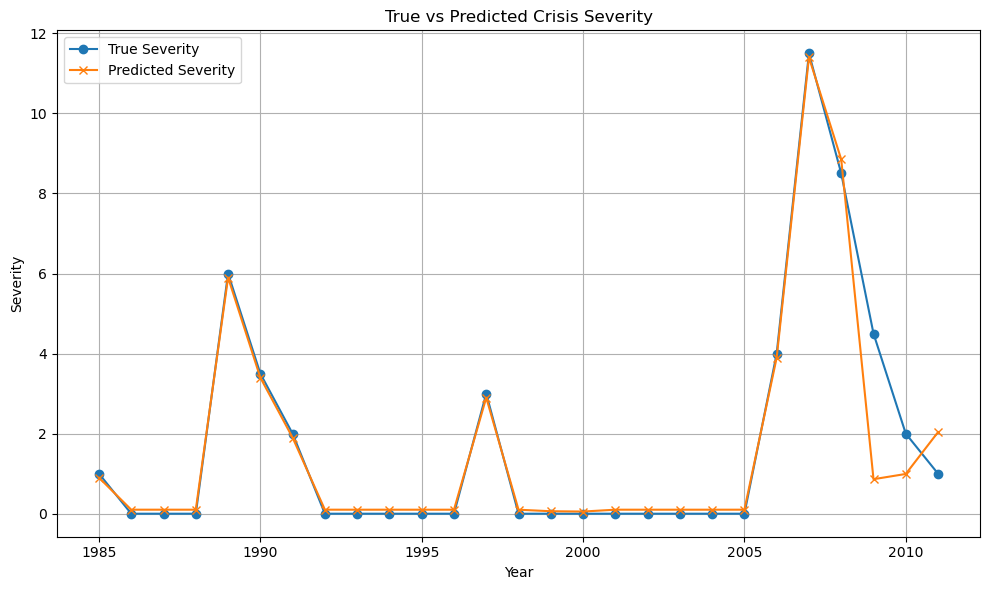

CPU times: total: 172 ms
Wall time: 175 ms


In [163]:
%%time
import matplotlib.pyplot as plt

# 假设 linear_labels 和 predictions 分别是真实标签和预测结果

# 确保 linear_labels 和 predictions 的长度相同
# 使用 Matplotlib 绘制折线图
years = range(1985, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, labels, label='True Severity', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 不使用lm_dict，直接进行tf-idf(待修改）

In [113]:
#不用字典的版本
tfidf_vector = []
for year, group in data_sample.groupby('year'):
    # 为当前年份创建 TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # 将当前年份的文本数据转换为 TF-IDF 向量表示
    tfidf_data = tfidf_vectorizer.fit_transform(pd.Series(' '.join(group['processed_txt'])))
    
    words_set = tfidf_vectorizer.get_feature_names_out()
    print(words_set)

    # 将 TF-IDF 结果转换为 DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = words_set)
    tfidf_vector.append(tfidf_df)


['06320' '07039' '07054' ... 'zoo' 'zorn' 'zurich']
['007' '02108' '06438' ... 'zuckerman' 'zurich' 'zywicki']
['025' '05' '062' ... 'ziegler' 'zimmer' 'zone']
['010' '025' '05' ... 'zone' 'zorn' 'zwilich']
['02' '025' '05' ... 'zone' 'zorn' 'zuni']
['0047' '02' '033' ... 'zwickau' 'zwiebel' 'zydeco']
['00901' '020acr' '0300' ... 'zulli' 'zvi' 'zwerl']
['01' '02' '025' ... 'zukerman' 'zulu' 'zurich']
['00' '0000000' '01' ... 'zuffelato' 'zwilich' 'zydeco']
['02' '0273' '03' ... 'zucchini' 'zulu' 'zuppa']
['032' '041' '048' ... 'zucchini' 'zucotti' 'zulaf']
['005' '0115' '019' ... 'zulu' 'zumbar' 'zzzzz']
['000' '007' '010023375' ... 'zurita' 'zvi' 'zweig']
['004' '010' '018' ... 'zulutek' 'zutic' 'zvi']
['01' '010100' '0108' ... 'zwerger' 'zyban' 'zydeco']
['00' '00008' '0006' ... 'zulu' 'zvezda' 'zyuganov']
['00' '01' '010701' ... 'zucker' 'zurich' 'zwart']
['00002' '000066' '007' ... 'zwirner' 'zwonitz' 'zyrtecto']
['003' '01' '0157h7' ... 'zvi' 'zwelethu' 'zwirn']
['00' '01' '0102' 

In [ ]:
# 输出 TF-IDF 统计结果
for i, year_tfidf in enumerate(tfidf_vector):
    print(f"TF-IDF vectors for year {i + 1}:\n{year_tfidf}")